In [1]:
import sys
sys.path.append('/mnt/c/Users/maart/OneDrive/school/2021-2022/Thesis/project/05_extendedData/04_neo4jAPI')
import neo4jConnection
import neo4j
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import numpy as np
import pandas as pd

initiate connection with database

In [2]:
uri = 'bolt://localhost:7687'
user = 'neo4j'
pwd = '770strains'
connection = neo4jConnection.Connection(uri, user, pwd)
driver = connection.getDriver()

old code: notice ```WHERE EXISTS(c.CAI_normalized)```
```
def obtainData_work(tx: neo4j.Session, strain: str) -> neo4j.Result:
    result = tx.run("""
            MATCH (firstFeature:FEATURE {strain: $strain})
            WHERE NOT EXISTS { 
                MATCH (:FEATURE)-[:NEIGHBOUR]->(firstFeature)
            }
            MATCH (lastFeature:FEATURE {strain: $strain})
            WHERE NOT EXISTS { 
                MATCH (lastFeature:FEATURE)-[:NEIGHBOUR]->(:FEATURE)
            }
            MATCH genomePath = shortestPath((firstFeature)-[NEIGHBOURS*]->(lastFeature))
            WITH nodes(genomePath) AS genomeFeatures
            UNWIND genomeFeatures AS genomeFeature
            MATCH (genomeFeature)-[:ORTHOLOG]->(c:CLUSTER)
            WHERE EXISTS(c.CAI_normalized)
            RETURN 
                collect(c.CAI_normalized) AS CAI_normalized,
                collect(c.GC_normalized) AS GC_normalized,
                collect(c.number_genomes) AS number_genomes,
                collect(genomeFeature.feature_type) AS feature_types
        """, strain = strain)

    return result.values('CAI_normalized', 'GC_normalized', 'number_genomes', 'feature_types')[0]

def obtainData(driver: neo4j.Driver, strain: str) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    CAI_normailized = []
    GC_normalized = []
    number_genomes = []
    with driver.session() as session:
        [CAI_normalized, GC_normalized, number_genomes, feature_types] = session.read_transaction(obtainData_work, strain)

    return pd.Series(CAI_normalized), pd.Series(GC_normalized), pd.Series(number_genomes), pd.Series(feature_types)
```

In [3]:
def obtainData_work(tx: neo4j.Session, strain: str) -> neo4j.Result:
    result = tx.run("""
        MATCH (s:STRAIN {name: $strain})
        MATCH (firstFeature:FEATURE)-[:FEATURE_IN_STRAIN]->(s)
        WHERE NOT EXISTS { 
            MATCH (:FEATURE)-[:NEIGHBOUR]->(firstFeature)
        }
        MATCH (lastFeature:FEATURE)-[:FEATURE_IN_STRAIN]->(s)
        WHERE NOT EXISTS { 
            MATCH (lastFeature:FEATURE)-[:NEIGHBOUR]->(:FEATURE)
        }
        MATCH genomePath = 
            shortestPath((firstFeature)-[NEIGHBOURS*]->(lastFeature))
        WITH nodes(genomePath) AS genomeFeatures, s
        UNWIND genomeFeatures AS genomeFeature
        MATCH (genomeFeature)-[:ORTHOLOG]->(c:CLUSTER)
        RETURN 
            genomeFeature.feature_id AS feature_id,
            genomeFeature.feature_start as feature_start,
            (genomeFeature.CAI-s.avg_CAI)/s.stDev_CAI AS CAI_normalized,
            (genomeFeature.GC-s.avg_GC)/s.stDev_GC AS GC_normalized,
            c.number_genomes AS number_genomes,
            genomeFeature.feature_type AS feature_types,
            c.hasBlastVirusHit as hasBlastVirusHit
        """, strain = strain)

    return result.values('feature_id', 'feature_start', 'CAI_normalized', 'GC_normalized', 'number_genomes', 'feature_types', 'hasBlastVirusHit')

In [4]:
def obtainData(driver: neo4j.Driver, strain: str) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    dict = {'feature_id': [], 'feature_start':[], 'CAI_normalized': [], 'GC_normalized': [], 'number_genomes': [], 'feature_types': [], 'hasBlastVirusHit': []}
    with driver.session() as session:
        result = session.read_transaction(obtainData_work, strain)
        for record in result:
            [feature_id, feature_start, CAI_normalized, GC_normalized, number_genomes, feature_types, hasBlastVirusHit] = record
            dict['feature_id'].append(feature_id)
            dict['feature_start'].append(feature_start)
            dict['CAI_normalized'].append(CAI_normalized)
            dict['GC_normalized'].append(GC_normalized)
            dict['number_genomes'].append(number_genomes)
            dict['feature_types'].append(feature_types)
            dict['hasBlastVirusHit'].append(hasBlastVirusHit)

    sequenceData = pd.DataFrame.from_dict(dict)

    deviating_CAI = pd.Series(index=range(sequenceData['CAI_normalized'].size), dtype=int)
    deviating_CAI.loc[abs(sequenceData['CAI_normalized']) >= 1.5] = 1
    deviating_CAI.loc[deviating_CAI != True] = 0
    sequenceData['deviating_CAI'] = deviating_CAI

    deviating_GC = pd.Series(index=range(sequenceData['GC_normalized'].size), dtype=int)
    deviating_GC.loc[abs(sequenceData['GC_normalized']) >= 1.5] = 1
    deviating_GC.loc[deviating_GC != True] = 0
    sequenceData['deviating_GC'] = deviating_GC
    return sequenceData

## Plot PAO1

In [29]:
sequenceData = obtainData(driver, 'GCA_000014625_1')

plot with x-axis n with the n-th gene

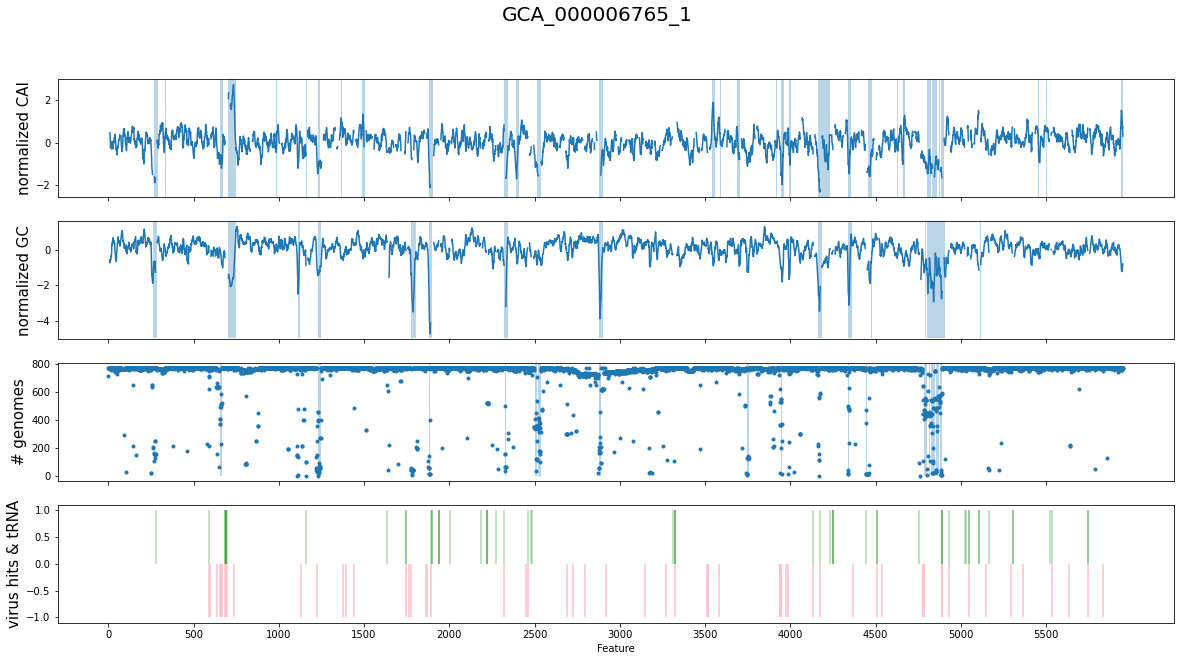

In [30]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10), sharex=True)
fig.suptitle('GCA_000006765_1', size=20)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'].rolling(window=10).mean(), '-')
ax1.set_ylabel('normalized CAI', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'].rolling(window=10).mean(), '-')
ax2.set_ylabel('normalized GC', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')

# tick labels at bottom for position in genome
tickInterval = 500
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
# plt.xlim(4700,5000)

plt.show()

plot with x-axis the start position in the genome

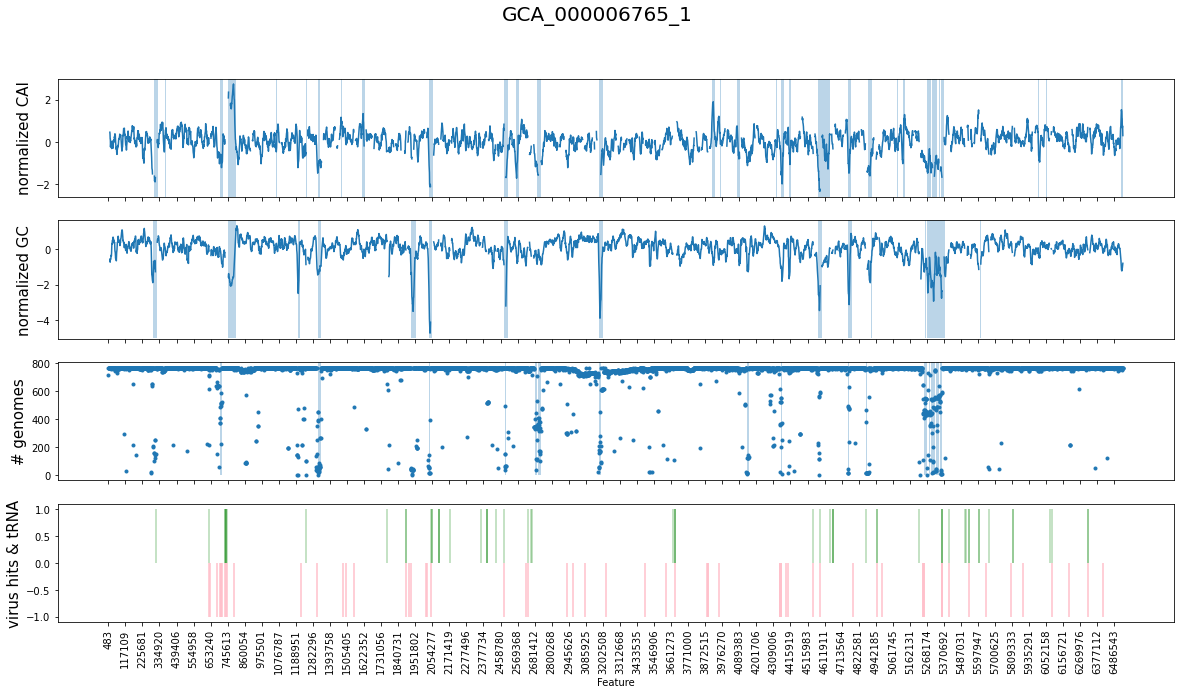

In [31]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10), sharex=True)
fig.suptitle('GCA_000006765_1', size=20)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'].rolling(window=10).mean(), '-')
ax1.set_ylabel('normalized CAI', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'].rolling(window=10).mean(), '-')
ax2.set_ylabel('normalized GC', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')

# tick labels at bottom for position in genome
tickInterval = 100
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

# plt.xlim(4700,5000)

plt.show()

# Plot for LESB58

In [5]:
sequenceData = obtainData(driver, 'GCA_000026645_1')

x-axis: nth gene

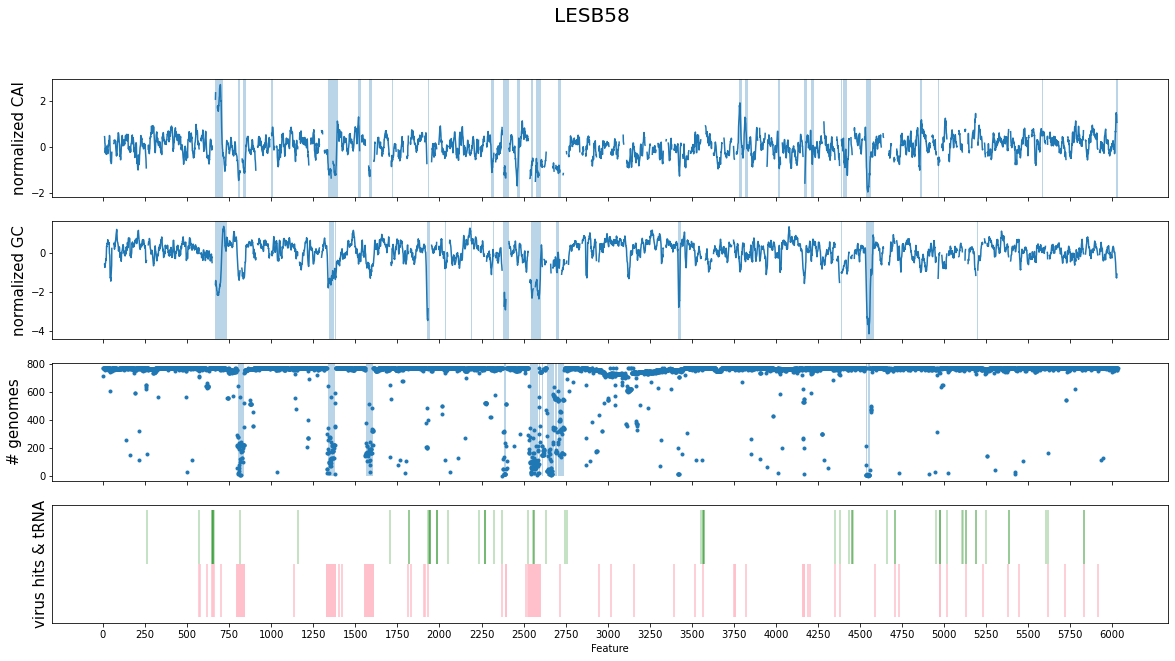

In [6]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10), sharex=True)
fig.suptitle('LESB58', size=20)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'].rolling(window=10).mean(), '-')
ax1.set_ylabel('normalized CAI', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'].rolling(window=10).mean(), '-')
ax2.set_ylabel('normalized GC', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 250
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
# plt.xlim(2500,2750)
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/LESB58_Genome.png')
plt.show()

x-axis: start feature

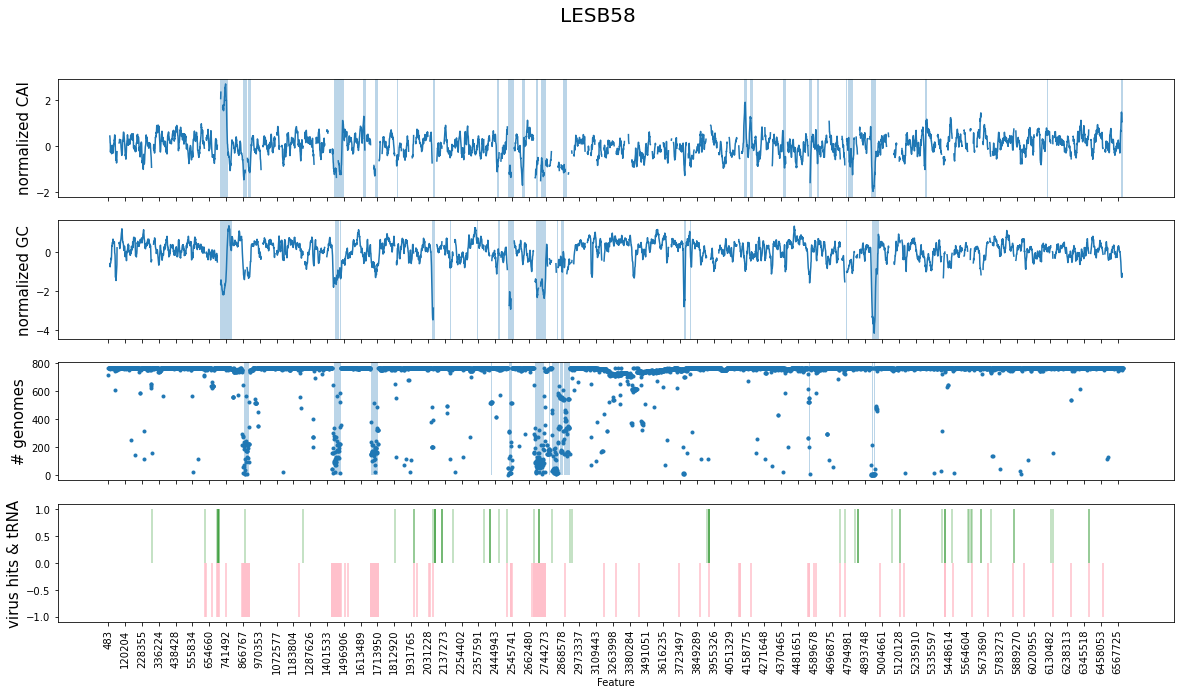

In [40]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10), sharex=True)
fig.suptitle('LESB58', size=20)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'].rolling(window=10).mean(), '-')
ax1.set_ylabel('normalized CAI', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'].rolling(window=10).mean(), '-')
ax2.set_ylabel('normalized GC', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = -5, ymax = 5, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 100
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

# plt.xlim(500,750)

plt.show()

## Prophages

prophage 1

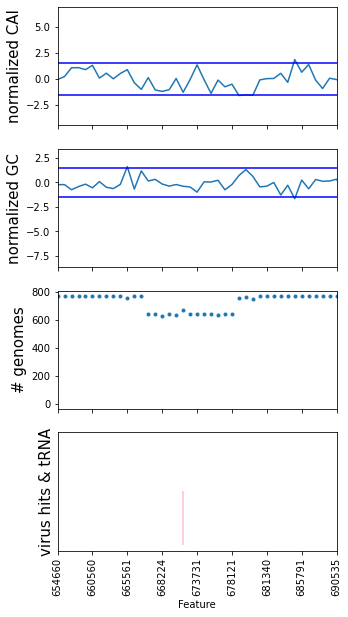

In [112]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(600,640)

plt.show()

prophage 2

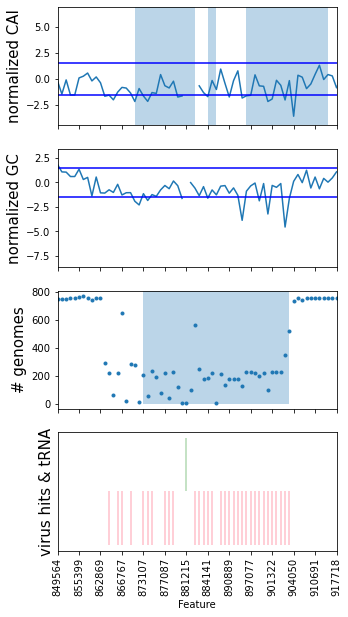

In [113]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(785,850)

plt.show()

prophage 3

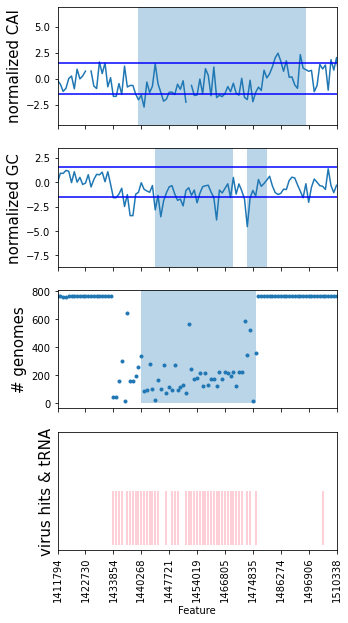

In [114]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 10
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(1310,1410)

plt.show()

prophage 4

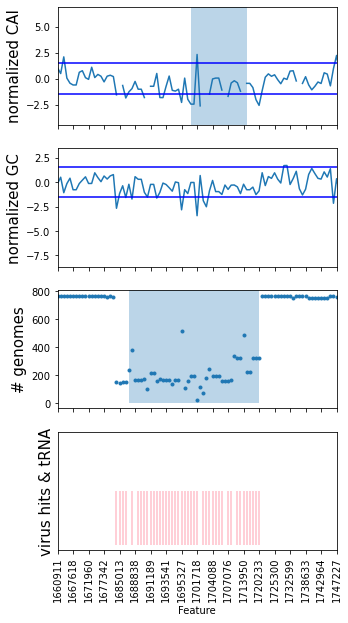

In [115]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(1540,1630)

plt.show()

prophage 5

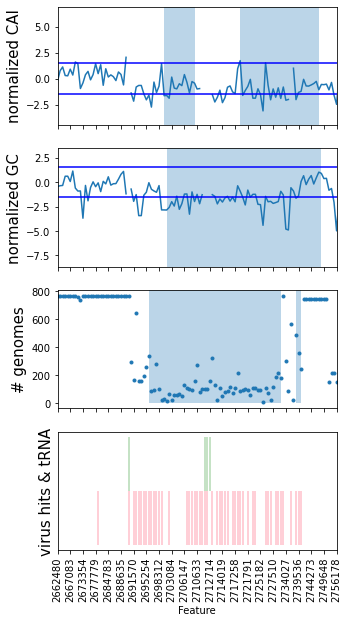

In [116]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(2500,2610)

plt.show()

prophage 6

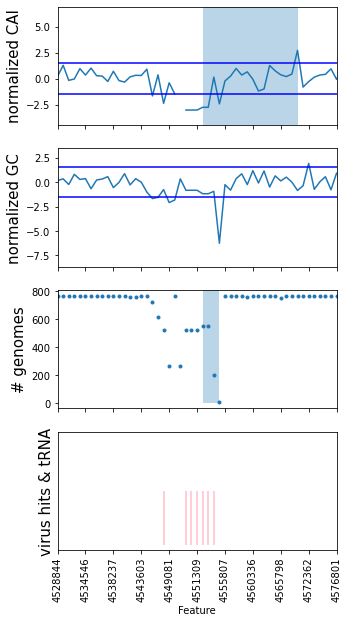

In [117]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(4140,4190)

plt.show()

## GIs

LESGI-1

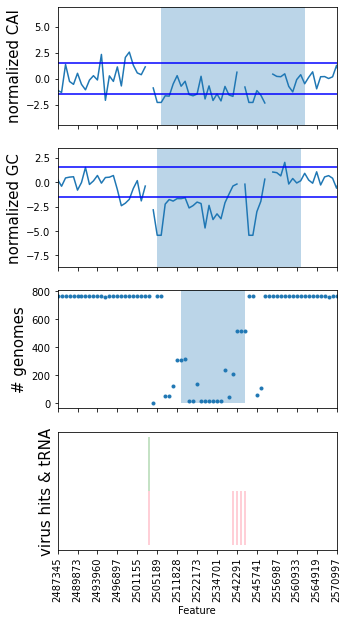

In [108]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(2350,2420)

plt.show()

LESGI-2

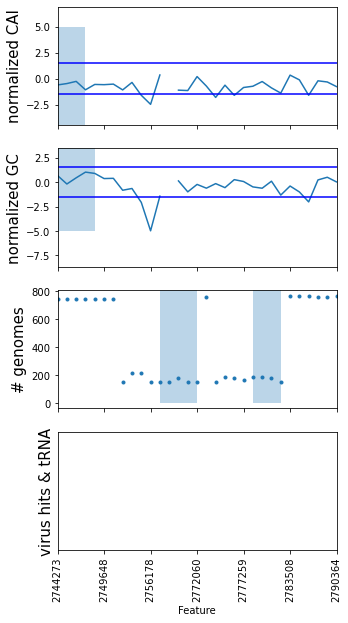

In [107]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(2600,2630)

plt.show()

LESGI-3

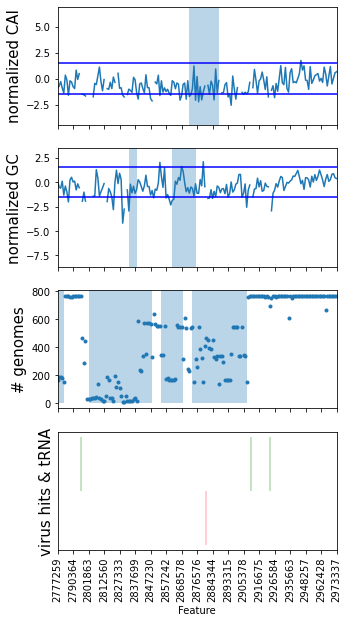

In [109]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 10
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(2620,2800)

plt.show()

LESGI-4

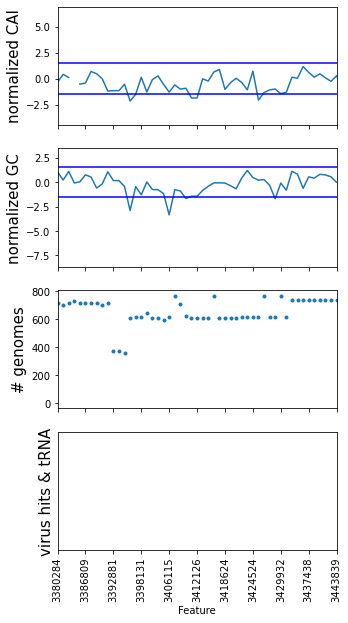

In [110]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(3100,3150)

plt.show()

LESGI-5

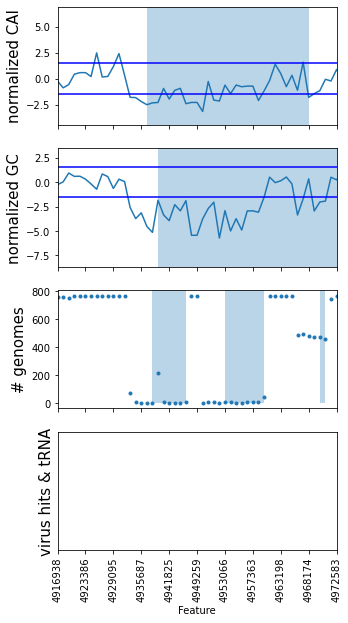

In [111]:
x = np.arange(0, sequenceData['CAI_normalized'].size)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,10), sharex=True)

# CAI plot

ax1.plot(sequenceData['CAI_normalized'], '-')
ax1.set_ylabel('normalized CAI', size=15)
ax1.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax1.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_CAI'].rolling(window=20).sum()>5, alpha = 0.3)
ax1.add_collection(collection)

# GC plot

ax2.plot(sequenceData['GC_normalized'], '-')
ax2.set_ylabel('normalized GC', size=15)
ax2.hlines(1.5, 0, sequenceData['CAI_normalized'].size, color='blue')
ax2.hlines(-1.5, 0, sequenceData['CAI_normalized'].size, color='blue')

collection = collections.BrokenBarHCollection.span_where(x, ymin = -10, ymax = 10, where=sequenceData['deviating_GC'].rolling(window=20).sum()>5, alpha = 0.3)
ax2.add_collection(collection)

# number genomes plot

ax3.plot(sequenceData['number_genomes'], '.')
ax3.set_ylabel('# genomes', size=15)

collection = collections.BrokenBarHCollection.span_where(x, ymin = 0, ymax = 1000, where=sequenceData['number_genomes'].rolling(window=5).max()<=600, alpha = 0.3)
ax3.add_collection(collection)

ax4.vlines(sequenceData[sequenceData['hasBlastVirusHit']==True].index, ymin=-1, ymax=0, colors='pink')
ax4.vlines(sequenceData[sequenceData['feature_types']=='tRNA'].index, ymin = 0, ymax=1, colors='green', alpha=0.3)
ax4.set_ylabel('virus hits & tRNA', size=15)
ax4.set_xlabel('Feature')
ax4.set_yticks([])

# tick labels at bottom for position in genome
tickInterval = 5
ax4.set_xticks(np.arange(0,sequenceData['CAI_normalized'].size, tickInterval))
ax4.set_xticklabels(sequenceData['feature_start'].iloc[np.arange(0,sequenceData['CAI_normalized'].size, tickInterval)], rotation=90)

plt.xlim(4520,4570)

plt.show()